In [1]:
import pandas as pd

# TODO: update for state
STATE = 'tx'
YEARS = [str(yr) for yr in range(2018, 2021)]

In [4]:
"""
File naming convension for ACS 5-year downloads:
state_year_[race|income].csv

"""

def get_filepath(state):
    return '../data/{state}/'.format(state=state)

def get_fname(state, year, dataset_type):
    return '{state}_{year}_{dataset_type}.csv'.format(
        state=state, year=year, dataset_type=dataset_type)

def get_filename(state, year, dataset_type):
    return get_filepath(state) + get_fname(state, year, dataset_type)


# geoid is the column we join data on
geoid_column_name = 'geoid'

geoid_column_map = {
    'GEO.id2': geoid_column_name,
    'GEO_ID': geoid_column_name
}

# for some reason particular file(s) have different column names- WHY?!
filename_income_column_map = {
    'ma_2017_income.csv': {
        'HC03_EST_VC02': 'median income',
        'HC03_MOE_VC02': 'median income margin of error',
        'HD01_VD01': 'median income',
        'HD02_VD01': 'median income margin of error'
    }
}
# Here is the default
income_column_map = {
    'HC02_EST_VC02': 'median income',
    'HC02_MOE_VC02': 'median income margin of error',
    'HD01_VD01': 'median income',
    'HD02_VD01': 'median income margin of error'
}

new_income_map = {
    'S1903_C03_001E': 'median income',
    'S1903_C03_001M': 'median income margin of error'
}

race_column_map = {
    'HD01_VD01': 'race: total households',
    'HD02_VD01': 'race: total households margin of error',
    'HD01_VD02': 'race: White',
    'HD01_VD03': 'race: Black',
    'HD01_VD05': 'race: Asian',
    'HD01_VD08': 'race: 2 or more races',
    # The following are combined into one value
    # 'HD01_VD04': 'race: American Indian and Alaska',
    # 'HD01_VD06': 'race: Native Hawaiian and Other',
    'HD01_VD07': 'race: Other',
}

new_race_column_map = {
    'B02001_001E': 'race: total households',
    'B02001_001M': 'race: total households margin of error',
    'B02001_002E': 'race: White',
    'B02001_003E': 'race: Black',
    'B02001_005E': 'race: Asian',
    'B02001_008E': 'race: 2 or more races',
    'B02001_007E': 'race: Other'
}

def race_combine_other(row):
    
    """Combines the values for the other races with american indian, hawaiian, etc"""
    try:
        return int(row['HD01_VD04']) + int(row['HD01_VD06']) + int(row['HD01_VD07'])
    except:
        return int(row['B02001_004E']) + int(row['B02001_006E']) + int(row['B02001_007E'])

def col_name_for_year(year, col_name):
    return str(year) + ' ' + col_name

def remove_labels(df):
    # drop the first row (the first row is a display label)
    df.drop([0], inplace=True)

def preprocess_df(df, year, column_map):
    # prune data
    #data from 2018-onwards only has GEO_ID not GEO.id2
    if int(year) >= 2017:
        for num in range(1, df.shape[0]+1):
            df.at[num, 'GEO_ID'] = df.at[num, 'GEO_ID'][-11:]
        
    # rename columns
    column_name_map = {key: col_name_for_year(year, value) for key, value in column_map.items()}
    
    column_name_map.update(geoid_column_map)
    cols_to_drop = [col for col in df.columns if not col in column_name_map.keys()]

    df.drop(cols_to_drop,  axis=1,  inplace=True)
    df.rename(columns=column_name_map, inplace=True)
    df.set_index(geoid_column_name, inplace=True)
    return df


def get_race_df(state, year):
    filename = get_filename(STATE, year, 'race')
    df = pd.read_csv(filename)
    remove_labels(df)
    # if int(year) < 2018:
    #     column = 'HD01_VD07'
    # else:
    #     column = 'B02001_007E'
    df['column'] = df.apply(race_combine_other, axis=1)
    if int(year) >= 2017:
        map = new_race_column_map
    else:
        map = race_column_map
    return preprocess_df(df, year, map)


def get_income_df(state, year):
    # so annoying that the columns change with files!
    if int(year) >= 2017:
        map = new_income_map
    else:
        map = income_column_map
    fname = get_fname(state, year, 'income')
    print('filename', fname)
    if fname in filename_income_column_map:
        map = filename_income_column_map[fname]
    df = pd.read_csv(get_filename(STATE, year, 'income'))
    remove_labels(df)
    return preprocess_df(df, year, map)


In [5]:
# We merge data into the income df

def add_df(df1, df2):
    # comebine the df's on geoid
    return pd.concat([df1, df2], axis=1, join='inner')

state_df = None
for year in YEARS:
    print('handling files for year ', year)
    income_df = get_income_df(STATE, year)
    if state_df is None:
        state_df = income_df
    else:
        state_df = add_df(state_df, income_df)
    print(state_df)
    race_df = get_race_df(STATE, year)
    state_df = add_df(state_df, race_df)

state_df.head()

handling files for year  2018
filename tx_2018_income.csv


C:\Users\Walter\AppData\Local\Temp\ipykernel_5844\2226537776.py:131: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,110,111,148,149) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(get_filename(STATE, year, 'income'))


            2018 median income 2018 median income margin of error
geoid                                                            
48001950100              54904                               5659
48001950401              53750                              45688
48001950402              85096                               7519
48001950500              35057                               6270
48001950600              52549                              16906
...                        ...                                ...
48505950400              28423                               5524
48507950100              14077                              12603
48507950200              25208                               8130
48507950301              28897                              13285
48507950302              34167                               8526

[5265 rows x 2 columns]
handling files for year  2019
filename tx_2019_income.csv


C:\Users\Walter\AppData\Local\Temp\ipykernel_5844\2226537776.py:131: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,110,111,148,149) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(get_filename(STATE, year, 'income'))


            2018 median income 2018 median income margin of error  \
geoid                                                               
48001950100              54904                               5659   
48001950401              53750                              45688   
48001950402              85096                               7519   
48001950500              35057                               6270   
48001950600              52549                              16906   
...                        ...                                ...   
48505950400              28423                               5524   
48507950100              14077                              12603   
48507950200              25208                               8130   
48507950301              28897                              13285   
48507950302              34167                               8526   

            2018 race: total households  \
geoid                                     
48001950100     

C:\Users\Walter\AppData\Local\Temp\ipykernel_5844\2226537776.py:131: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,110,111,148,149) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(get_filename(STATE, year, 'income'))


            2018 median income 2018 median income margin of error  \
geoid                                                               
48001950100              54904                               5659   
48001950401              53750                              45688   
48001950402              85096                               7519   
48001950500              35057                               6270   
48001950600              52549                              16906   
...                        ...                                ...   
48503950600              44572                               5217   
48507950100              14077                              12603   
48507950200              25208                               8130   
48507950301              28897                              13285   
48507950302              34167                               8526   

            2018 race: total households  \
geoid                                     
48001950100     

,2018 median income,2018 median income margin of error,2018 race: total households,2018 race: total households margin of error,2018 race: White,2018 race: Black,2018 race: Asian,2018 race: Other,2018 race: 2 or more races,2019 median income,...,2019 race: 2 or more races,2020 median income,2020 median income margin of error,2020 race: total households,2020 race: total households margin of error,2020 race: White,2020 race: Black,2020 race: Asian,2020 race: Other,2020 race: 2 or more races
geoid,,,,,,,,,,,,,,,,,,,,,
48001950100,54904,5659,5164,525,4657,312,14,50,112,58750,...,114,59675,9914,4958,736,4212,267,50,4,399
48001950401,53750,45688,4872,263,2860,1918,22,16,41,75938,...,43,84063,30550,4867,838,2594,1851,8,57,347
48001950402,85096,7519,7548,356,4296,3180,8,17,12,85921,...,15,-,**,7335,352,3827,2871,8,113,484
48001950500,35057,6270,4569,520,3349,759,0,273,169,36226,...,164,40000,8381,4397,575,3220,707,0,164,306
48001950600,52549,16906,5570,754,4026,1466,0,0,62,34821,...,54,39936,14035,4704,915,3226,1268,0,141,69


In [6]:
# Save the giant dataframe to CSV
output_csvfilename = get_filepath(STATE) + 'race_and_income_data.csv'
state_df.to_csv(output_csvfilename)
print('saved data to ',  output_csvfilename)

saved data to  ../data/tx/race_and_income_data.csv


In [8]:
import geopandas as gpd

In [43]:
"""Creates shapefile from NYC open data download.
This shapefile does not have geoids, so must add them based on its other data.

"""

NY_STATE_CODE = '36'

nyc_shapefile_attributes = {
    geoid_column_name: geoid_column_name,
    'ntaname': 'Name', # name of neighborhood in this dataset
    # Tracts are duplicated across boros.
    # The unique key is 'boro_ct201' which is the concatenation of boro id and ct
    # 'ct2010': 'tract',
    'shape_area': 'shape_area',
    'shape_leng': 'shape_leng',
    'geometry': 'geometry'
}
ma_shapefile_attributes = {
    'GEOID10': geoid_column_name,
    'NAMELSAD10': 'Name', # 'Census Tract ###'  in this dataset
    'SHAPE_AREA': 'shape_area',
    'SHAPE_LEN': 'shape_leng',
    'geometry': 'geometry'
}

hou_shapefile_attributes = {
    'GEOID': geoid_column_name,
    'NAMELSAD': 'Name',
    'AREA': 'shape_area',
    'geometry': 'geometry'
}

# Mapping of boro names to county code for geoid
# Taken from wikipedia info: https://en.wikipedia.org/wiki/List_of_counties_in_New_York
nyc_boro_to_county_code = {
    'Bronx':'005',
    'Queens':'081',
    'Brooklyn':'047',
    'Manhattan':'061',
    'Staten Island':'085'
}


def get_nyc_shapefile():
    shapefile_filename = get_filepath('ny') + 'city_census_tracts_shapefile/geo_export_6f3df1e4-1be2-4395-ba6c-3e15b0a10221.shp'
    shapefile_df = gpd.read_file(shapefile_filename)
    shapefile_df[geoid_column_name] = shapefile_df.apply(get_nyc_geoid, axis=1)
    return shapefile_df


def get_nyc_county_code(row):
    boro_name = row['boro_name']
    return nyc_boro_to_county_code[boro_name]


def get_nyc_geoid(row):
    state_code = NY_STATE_CODE
    county_code = get_nyc_county_code(row)
    tract_code = row['ct2010']
    return str(state_code) + str(county_code) + str(tract_code)

shapefile_df = None
if STATE == 'ny':
    shapefile_df = get_nyc_shapefile()
    shapefile_attributes = nyc_shapefile_attributes
elif STATE == 'ma':
    shapefile_filename = get_filepath(STATE) + 'shapefile/boston-brookline-cambridge-somerville-everett.shp'
    shapefile_df = gpd.read_file(shapefile_filename)
    shapefile_attributes = ma_shapefile_attributes
elif STATE == 'tx':
    shapefile_filename = get_filepath(STATE) + 'shapefiles/tl_2021_48_tract.shp'
    shapefile_df = gpd.read_file(shapefile_filename)
    shapefile_df = shapefile_df.loc[shapefile_df["COUNTYFP"] == '201']
    shapefile_df["AREA"] = shapefile_df["ALAND"].astype(int) + shapefile_df["AWATER"].astype(int)
    shapefile_attributes = hou_shapefile_attributes

shapefile_df


,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,AREA
12,48,201,341002,48201341002,3410.02,Census Tract 3410.02,G5020,S,1785065,0,+29.5503433,-095.1445136,"POLYGON ((-95.15404 29.55352, -95.15388 29.553...",1785065
13,48,201,310101,48201310101,3101.01,Census Tract 3101.01,G5020,S,2195579,20698,+29.7525284,-095.3436349,"POLYGON ((-95.35849 29.74977, -95.35784 29.750...",2216277
14,48,201,510301,48201510301,5103.01,Census Tract 5103.01,G5020,S,1435445,30134,+29.7824771,-095.3779390,"POLYGON ((-95.38810 29.77722, -95.38778 29.777...",1465579
15,48,201,311001,48201311001,3110.01,Census Tract 3110.01,G5020,S,830347,25333,+29.7457725,-095.3037286,"POLYGON ((-95.31009 29.74334, -95.30991 29.743...",855680
16,48,201,233502,48201233502,2335.02,Census Tract 2335.02,G5020,S,1380711,0,+29.7625516,-095.2458797,"POLYGON ((-95.25607 29.76793, -95.25185 29.767...",1380711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6871,48,201,250303,48201250303,2503.03,Census Tract 2503.03,G5020,S,2086010,6809,+29.9433313,-095.2393538,"POLYGON ((-95.24970 29.95052, -95.24970 29.950...",2092819
6872,48,201,250201,48201250201,2502.01,Census Tract 2502.01,G5020,S,4619977,13380,+29.9501906,-095.2569333,"POLYGON ((-95.26833 29.94201, -95.26829 29.942...",4633357
6873,48,201,532004,48201532004,5320.04,Census Tract 5320.04,G5020,S,1569963,31001,+29.8498715,-095.4657071,"POLYGON ((-95.47334 29.85794, -95.47314 29.857...",1600964
6874,48,201,532003,48201532003,5320.03,Census Tract 5320.03,G5020,S,1010818,12188,+29.8607474,-095.4707212,"POLYGON ((-95.48095 29.86575, -95.48038 29.865...",1023006


In [44]:
# Map column names and remove columns
shapefile_cols_to_drop = [col for col in shapefile_df.columns if not col in shapefile_attributes.keys()]
shapefile_df.drop(shapefile_cols_to_drop,  axis=1,  inplace=True)
shapefile_df.rename(columns=shapefile_attributes, inplace=True)
shapefile_df.set_index(geoid_column_name, inplace=True)
shapefile_df.head() 



,Name,geometry,shape_area
geoid,,,
48201341002,Census Tract 3410.02,"POLYGON ((-95.15404 29.55352, -95.15388 29.553...",1785065
48201310101,Census Tract 3101.01,"POLYGON ((-95.35849 29.74977, -95.35784 29.750...",2216277
48201510301,Census Tract 5103.01,"POLYGON ((-95.38810 29.77722, -95.38778 29.777...",1465579
48201311001,Census Tract 3110.01,"POLYGON ((-95.31009 29.74334, -95.30991 29.743...",855680
48201233502,Census Tract 2335.02,"POLYGON ((-95.25607 29.76793, -95.25185 29.767...",1380711


c:\Users\Walter\anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<AxesSubplot:>

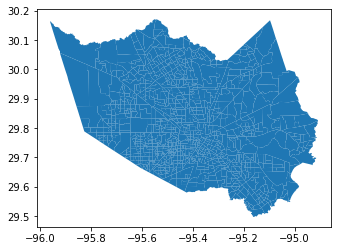

In [45]:
# Want projection CRS84 which is equivalent to EPSG:4326
shapefile_df = shapefile_df.to_crs({'init': 'epsg:4326'})

%matplotlib inline
shapefile_df.plot()

In [46]:
merged_shapes = shapefile_df.merge(state_df, on=geoid_column_name)
print('shape', merged_shapes.shape)
merged_shapes.head()

shape (485, 30)


,Name,geometry,shape_area,2018 median income,2018 median income margin of error,2018 race: total households,2018 race: total households margin of error,2018 race: White,2018 race: Black,2018 race: Asian,...,2019 race: 2 or more races,2020 median income,2020 median income margin of error,2020 race: total households,2020 race: total households margin of error,2020 race: White,2020 race: Black,2020 race: Asian,2020 race: Other,2020 race: 2 or more races
geoid,,,,,,,,,,,,,,,,,,,,,
48201240802,Census Tract 2408.02,"POLYGON ((-95.40544 30.03111, -95.40524 30.031...",13339418,50699,3840,6280,554,2600,2811,201,...,131,53638,6154,7913,1466,3245,3211,14,399,1044
48201421403,Census Tract 4214.03,"POLYGON ((-95.49319 29.71093, -95.49306 29.711...",654077,24767,3506,4131,447,3332,597,93,...,0,26548,5181,4294,587,2777,576,153,744,0
48201421402,Census Tract 4214.02,"POLYGON ((-95.48897 29.71638, -95.48874 29.716...",161245,25920,3745,3801,392,3172,207,113,...,0,25365,6395,3852,722,2176,172,78,986,421
48201423201,Census Tract 4232.01,"POLYGON ((-95.55612 29.65846, -95.55593 29.658...",1955246,74800,17118,3652,295,1428,1169,279,...,33,71081,16421,3025,314,1577,546,333,533,27
48201534203,Census Tract 5342.03,"POLYGON ((-95.55562 29.87358, -95.55544 29.873...",4243935,56000,15120,2226,231,1653,98,90,...,50,50417,15538,2430,403,1988,53,90,149,128


In [47]:
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon

In [48]:
to_filename = get_filepath(STATE) + STATE  + '_census_tracts.geojson'
print('saving to ',to_filename)
merged_shapes["geometry"] = [MultiPolygon([feature]) if type(feature) == Polygon \
    else feature for feature in merged_shapes["geometry"]]
merged_shapes.to_file(to_filename, driver='GeoJSON')
print('saved')
sort = False

saving to  ../data/tx/tx_census_tracts.geojson
saved
